# Code to generate impact based forecast

## Read and prepare data

In [1]:
# use ICON or COSMO
model = "cosmo1e" # "cosmo1e" "cosmo2e" "icon-ch1-eps" "icon-ch2-eps"

# global parameters
thresh_exp = 0 # minimal threshold (number of buildings) when reading exposure and imapcts


In [2]:
#######################
### import packages ###
#######################

import warnings  # To hide the warnings
warnings.filterwarnings("ignore")
import numpy as np
import datetime as dt
import json
import geopandas as gpd
import pandas as pd
from pathlib import Path
import matplotlib as mpl
import cartopy.crs as ccrs

from climada import CONFIG
from climada.hazard import Hazard
from climada.entity import ImpactFuncSet, Exposures
from climada.engine import ImpactCalc

import util_plot as u_plot
import utils 

# # define directories
ch_shp_path = f"{CONFIG.local_data.data_dir}/ch_shapefile"
dir_plots = f"{CONFIG.local_data.plot_dir}/hailcast_threshold_warnings"
dir_damage = f"{CONFIG.local_data.data_dir}/damage/"
f_damage = f"{dir_damage}ds_building_dmg_v71_1000m.nc"
exp_file_path = f"{CONFIG.local_data.data_dir}/Exposures/buildings_CH/exposure_buildings_ch.h5"
dir_impf = f"{CONFIG.local_data.data_dir}/HailCast/impf/"
if model in ["cosmo1e", "cosmo2e"]:
    dir_cosmo = f"{CONFIG.local_data.data_dir}/HailCast/forecast/{model}/max_66UTC/"
else:
    dir_cosmo = f"{CONFIG.local_data.data_dir}/HailCast/forecast/{model}/reforecast/max_66UTC/"


In [3]:
###################
#### load data ####
###################

# read warning shapefile
warning_shape=gpd.read_file(f"{ch_shp_path}/warning_regions/Warningregions.shp")
warning_shape.crs = ccrs.epsg(21781)
warning_shape = warning_shape[["REGION_NAM", "geometry"]]
warning_shape = warning_shape.to_crs(epsg=2056)


# create date list exluding days with no available forecasts
date_list = pd.concat([
    pd.Series(index=pd.date_range("2021-04-01", "2021-09-30", freq='D')),
    pd.Series(index=pd.date_range("2022-04-01", "2022-09-30", freq='D')),
    pd.Series(index=pd.date_range("2023-04-01", "2023-09-30", freq='D')),
]).index
date_list = date_list.drop(
    ['2022-06-04', '2022-06-05', '2022-06-07', '2022-06-16', '2022-06-17', '2022-06-22', '2022-06-23',
     '2022-06-29', '2022-06-30', '2022-07-01', '2022-07-07', '2022-07-09', '2023-04-01'])
n_days = len(date_list)

# read exposure and impact
exp_insurance, exp_insurance_2D, imp_observed, imp_coord_observed = utils.load_exposure_and_impacts(
    f_damage, 'n_count_exposure', thresh_exp, n_days, date_list
)

# read BFS exposure
exp_n_build = Exposures.from_hdf5(exp_file_path) # BFS exposure layer (all of Switzerland)
# cut to four validation cantons
cantons = gpd.read_file(f"{ch_shp_path}/swissTLMRegio_KANTONSGEBIET_LV95.shp")
cantons = cantons.to_crs(epsg=2056)
aggregated_gdf = cantons.dissolve(by="NAME", as_index=False)
aggregated_gdf = aggregated_gdf.loc[aggregated_gdf.ICC == "CH", :].reset_index(
    drop=True
)
validation_cantons_gdf = aggregated_gdf.iloc[[0, 5, 11, 25]]
exp_n_build_4cantons = exp_n_build.copy()
exp_n_build_4cantons.data = exp_n_build.data.loc[validation_cantons_gdf.geometry.unary_union.contains(exp_n_build.data.geometry.to_crs(ccrs.epsg(2056)))]
exp_n_build_per_canton = [exp_n_build.copy() for i in range(26)]
for i in range(26):
    exp_n_build_per_canton[i].data = exp_n_build.data.loc[aggregated_gdf.iloc[i].geometry.contains(exp_n_build.data.geometry.to_crs(ccrs.epsg(2056)))]
n_build_BFS_per_canton =  np.array([exp.gdf["value"].sum() for exp in exp_n_build_per_canton])
n_build_BFS_per_validation_canton = n_build_BFS_per_canton[[0, 5, 11, 25]]

# read observed impact per canton
gdf_impact_observed = gpd.GeoDataFrame(geometry = exp_insurance.gdf.geometry.to_crs(ccrs.epsg(2056)))
gdf_impact_observed[date_list] = imp_observed.T
dmgs_observed_per_validation_canton = [0. for i in range(4)]
exp_insurance_per_validation_canton = [0. for i in range(4)]
for i, ind_canton in enumerate([0, 5, 11, 25]):
    dmgs_observed_per_validation_canton[i] = gdf_impact_observed.loc[aggregated_gdf.iloc[[ind_canton]].geometry.unary_union.contains(gdf_impact_observed.geometry.to_crs(ccrs.epsg(2056)))].values[:,1:].sum(axis=0)
    exp_insurance_per_validation_canton[i] = exp_insurance.gdf.loc[aggregated_gdf.iloc[[ind_canton]].geometry.unary_union.contains(gdf_impact_observed.geometry.to_crs(ccrs.epsg(2056)))]["value"].sum()

# read hazards
if model in ["cosmo1e", "cosmo2e"]:
    n_members = 11 if model=="cosmo1e" else 21
    run = 6 
else:
    n_members = 11 if model=="icon-ch1-eps" else 21
    run="flexible"
dir_hazard = f"hailcast_{model}_2021_2023.h5"

if Path.cwd().joinpath(dir_hazard).exists():
    haz = Hazard.from_hdf5(dir_hazard)
    haz.event_name = haz.event_id
else:
    haz = utils.load_and_preprocess_hazard(dir_cosmo, run, date_list)
    haz.write_hdf5(dir_hazard)


Centroids before subsetting: 33366
Centroids after subsetting:   9170
2025-08-13 16:56:24,212 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2025-08-13 16:56:24,213 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2025-08-13 16:56:24,213 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2025-08-13 16:56:24,214 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity thre

## Create warning maps

### Cantonal warning map

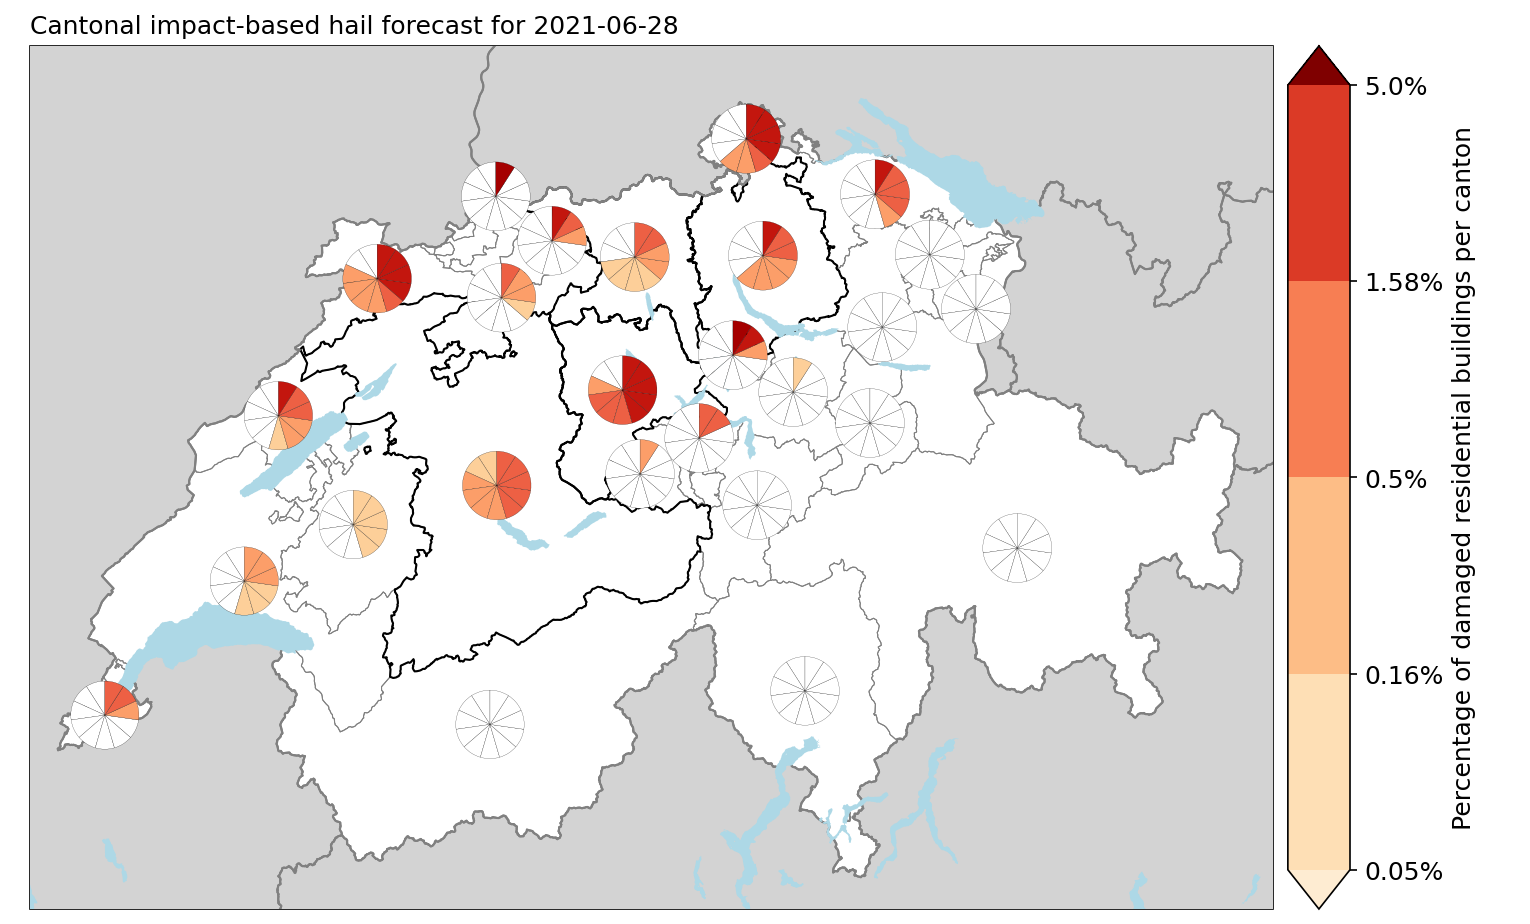

In [4]:
example_date = "2021-06-28"
ids_example_date = np.argwhere(np.array(haz.get_event_date()) == example_date).flatten()
haz_example_date = haz.select(event_id=ids_example_date)

dt_day = dt.datetime.fromisoformat(example_date)
dt_init = dt_day+pd.Timedelta(6,'h')

# load impact functions (forecast calibrated with n buildings)
#### ATTENTION #####
# before running this for the first time impact function have to be calibrated -> run .\impact_function_calibration.ipynb
####################
impf_params = {}
for impf_name in ['paa_flex', 'paa_Q0.05_flex', 'paa_Q0.95_flex']:
    path_impf = f'{dir_impf}/i_{model}_2021-04-01-2023-09-30_{impf_name}.json'
    f = open(path_impf)
    impf_params[impf_name] = json.load(f)
    f.close()

impfset_flex = ImpactFuncSet([utils.get_emanuel_impf(**impf_params['paa_flex'])])
impfset_flex_Q05 = ImpactFuncSet([utils.get_emanuel_impf(**impf_params['paa_Q0.05_flex'])])
impfset_flex_Q95 = ImpactFuncSet([utils.get_emanuel_impf(**impf_params['paa_Q0.95_flex'])])

imp_cal_flex = ImpactCalc(exp_n_build, impfset_flex, haz_example_date).impact(save_mat=True)
imp_cal_flex_Q05 = ImpactCalc(exp_n_build, impfset_flex_Q05, haz_example_date).impact(save_mat=True)
imp_cal_flex_Q95 = ImpactCalc(exp_n_build, impfset_flex_Q95, haz_example_date).impact(save_mat=True)


cmap = u_plot.get_cmap_killian(name="OrRd")
fig = u_plot.plot_cantonal_imp(imp_cal_flex, exp_n_build, dt_day, dt_init, cmap, data_source=f'Cantonal impact-based hail forecast for {example_date}', show_init_valid=False)
# fig.savefig(f"{dir_plots}/cantonal_damage_forecast_{model}_date{example_date}.png", bbox_inches='tight')

### Nation-wide warning map

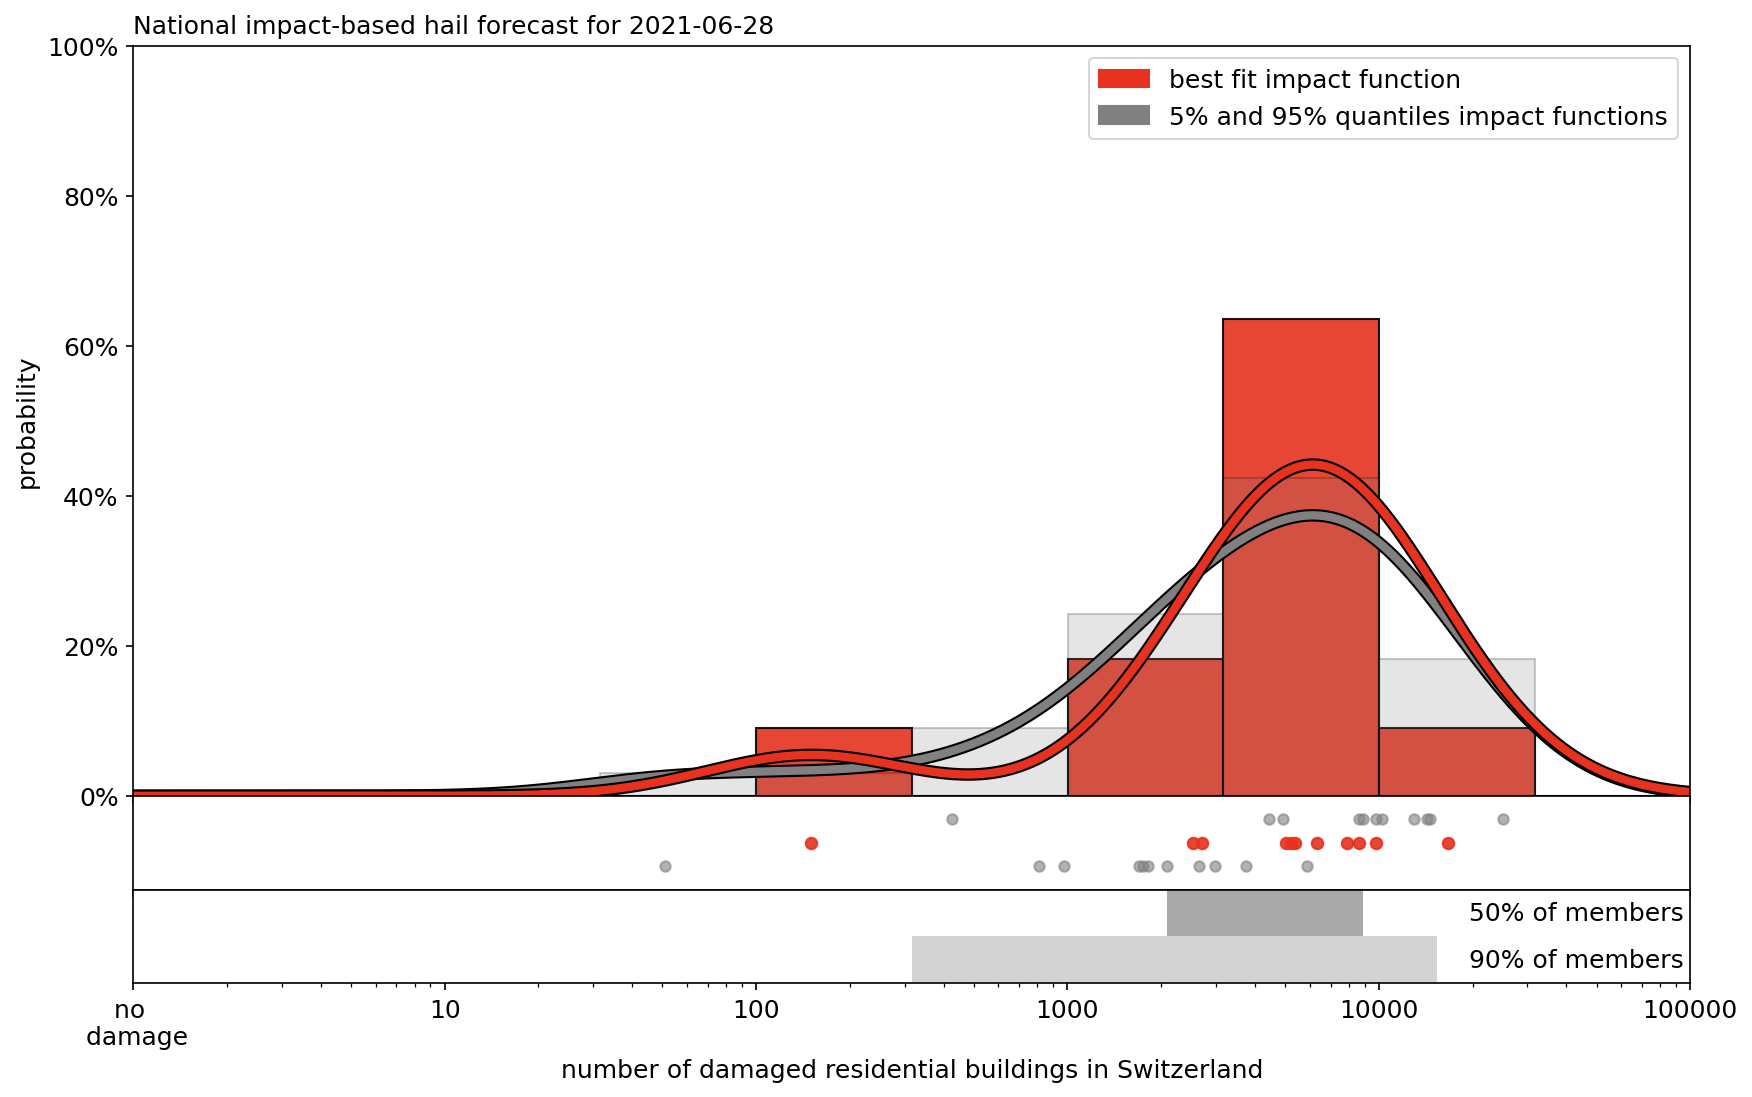

In [5]:
fig = u_plot.plot_imp_hist(imp_cal_flex, imp_cal_flex_Q05, imp_cal_flex_Q95, dt_day, dt_init, data_source=f'National impact-based hail forecast for {example_date}', show_init_valid=False)
# fig.savefig(f"{dir_plots}/country_damage_forecast_{model}_date{example_date}.png", bbox_inches='tight')

## Evaluation and skill metrics

### Cantonal warning map

In [6]:
###################################
### evaluation cantonal forcast ###
###################################

imp_cal_flex_per_canton = [ImpactCalc(exp, impfset_flex, haz).impact() for exp in exp_n_build_per_canton]
dmgs_mod_per_canton = np.array([imp.at_event.reshape(-1, n_members)for imp in imp_cal_flex_per_canton])

dmgs_mod_per_validation_canton = dmgs_mod_per_canton[[0, 5, 11, 25]]
dmgs_mod_per_validation_canton_combined = np.concatenate(dmgs_mod_per_validation_canton, axis=0)

dmgs_observed_per_validation_canton_combined = np.concatenate(dmgs_observed_per_validation_canton, axis=0)

# compute some skills about absolute forecasts
print("skills of absolute cantonal forecasts")
for skill, qmin, qmax, min_threshold_on_observed in zip(
    ["in 0-100 range", "in 5-95 range", "in 25-75 range", "in 0-100 range of damage days", "in 5-95 range of damage days", "in 25-75 range of damage days", "median above 1 of no-damage days"],
    [0., .05, .25, 0., .05, .25],
    [1., .95, .75, 1., .95, .75],
    [0, 0, 0, 1, 1, 1]
):
    rate = utils.rate_reported_in_qunatile_range(dmgs_mod_per_validation_canton_combined, dmgs_observed_per_validation_canton_combined, qmin, qmax, min_threshold_on_observed, n_members=n_members)
    print(f"{skill}: {rate}")
for skill, q in zip(
    ["median above 1 of no-damage days", "max above 1 of no-damage days"],
    [.5, 1.]
):
    rate = utils.rate_quantile_above_1(dmgs_mod_per_validation_canton_combined, dmgs_observed_per_validation_canton_combined, q, max_threshold_on_observed=1, n_members=n_members)
    print(f"{skill}: {rate}")

# compute some skills about absolute forecasts
print("\nskills of relative cantonal forecasts")
for skill, qmin, qmax, min_threshold_on_observed in zip(
    ["in 0-100 range", "in 5-95 range", "in 25-75 range", "in 0-100 range of damage days", "in 5-95 range of damage days", "in 25-75 range of damage days", "median above 1 of no-damage days"],
    [0., .05, .25, 0., .05, .25],
    [1., .95, .75, 1., .95, .75],
    [0, 0, 0, 1, 1, 1]
):
    rate = utils.rate_reported_in_qunatile_range(dmgs_mod_per_validation_canton_combined, dmgs_observed_per_validation_canton_combined, qmin, qmax, min_threshold_on_observed, n_members=n_members,
        exp_modelled=n_build_BFS_per_validation_canton, exp_observed=exp_insurance_per_validation_canton,)
    print(f"{skill}: {rate}")

skills of absolute cantonal forecasts
in 0-100 range: 0.9430970149253731
in 5-95 range: 0.9379664179104478
in 25-75 range: 0.8936567164179104
in 0-100 range of damage days: 0.5405405405405406
in 5-95 range of damage days: 0.5212355212355212
in 25-75 range of damage days: 0.2548262548262548
median above 1 of no-damage days: 0.01273209549071618
max above 1 of no-damage days: 0.09018567639257294

skills of relative cantonal forecasts
in 0-100 range: 0.9472947761194029
in 5-95 range: 0.9388992537313433
in 25-75 range: 0.8955223880597015
in 0-100 range of damage days: 0.5752895752895753
in 5-95 range of damage days: 0.528957528957529
in 25-75 range of damage days: 0.2702702702702703


### Nation-wide warning map

In [7]:
##################################
### evaluation 4canton forcast ###
##################################

# compute aggreagted forecast for four cantons
imp_cal_flex_4cantons = ImpactCalc(exp_n_build_4cantons, impfset_flex, haz).impact()
imp_cal_flex_Q05_4cantons = ImpactCalc(exp_n_build_4cantons, impfset_flex_Q05, haz).impact()
imp_cal_flex_Q95_4cantons = ImpactCalc(exp_n_build_4cantons, impfset_flex_Q95, haz).impact()
dmgs_mod_4cantons = imp_cal_flex_4cantons.at_event.reshape(-1, n_members)
dmgs_mod_Q05_4cantons = imp_cal_flex_Q05_4cantons.at_event.reshape(-1, n_members)
dmgs_mod_Q95_4cantons = imp_cal_flex_Q95_4cantons.at_event.reshape(-1, n_members)
dmgs_combined_4cantons = np.concatenate((dmgs_mod_4cantons, dmgs_mod_Q05_4cantons, dmgs_mod_Q95_4cantons), axis = 1)

# compute observed impacts
dmg_observed_4cantons = np.sum(imp_observed, axis=1)

# compute some skills
for skill, qmin, qmax, min_threshold_on_observed in zip(
    ["in 0-100 range", "in 5-95 range", "in 25-75 range", "in 0-100 range of damage days", "in 5-95 range of damage days", "in 25-75 range of damage days", "median above 1 of no-damage days"],
    [0., .05, .25, 0., .05, .25],
    [1., .95, .75, 1., .95, .75],
    [0, 0, 0, 1, 1, 1]
):
    rate = utils.rate_reported_in_qunatile_range(dmgs_combined_4cantons, dmg_observed_4cantons, qmin, qmax, min_threshold_on_observed, n_members=n_members*3)
    print(f"{skill}: {rate}")
for skill, q in zip(
    ["median above 1 of no-damage days", "95 qunatile above 1 of no-damage days"],
    [.5, .95]
):
    rate = utils.rate_quantile_above_1(dmgs_combined_4cantons, dmg_observed_4cantons, q, max_threshold_on_observed=1, n_members=n_members*3)
    print(f"{skill}: {rate}")


in 0-100 range: 0.9048507462686567
in 5-95 range: 0.8880597014925373
in 25-75 range: 0.8059701492537313
in 0-100 range of damage days: 0.6370370370370371
in 5-95 range of damage days: 0.5703703703703704
in 25-75 range of damage days: 0.26666666666666666
median above 1 of no-damage days: 0.00997506234413965
95 qunatile above 1 of no-damage days: 0.09975062344139651


OOM of 0.0-1.0 quantile of 72 events:  3.0561838002075064.
OOM of 0.05-0.95 quantile of 72 events:  2.4332794442932815.
OOM of 0.25-0.75 quantile of 72 events:  0.9546794430794379.


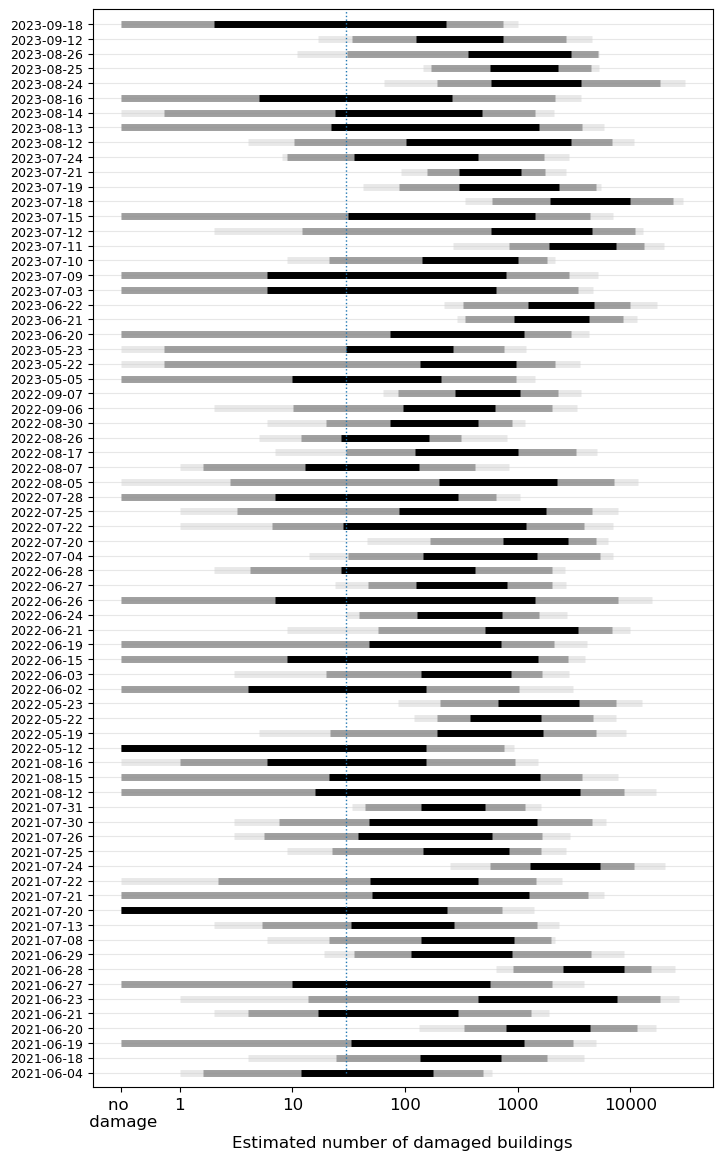

In [8]:
#############################
### OOM largest forecasts ###
#############################

# compute all nation-wide impact forecasts 
imp_cal_flex = ImpactCalc(exp_n_build, impfset_flex, haz).impact(save_mat=True)
imp_cal_flex_Q05 = ImpactCalc(exp_n_build, impfset_flex_Q05, haz).impact(save_mat=True)
imp_cal_flex_Q95 = ImpactCalc(exp_n_build, impfset_flex_Q95, haz).impact(save_mat=True)
dmgs_mod = imp_cal_flex.at_event.reshape(-1, n_members)
dmgs_mod_Q05 = imp_cal_flex_Q05.at_event.reshape(-1, n_members)
dmgs_mod_Q95 = imp_cal_flex_Q95.at_event.reshape(-1, n_members)
dmgs_combined_ch = np.concatenate((dmgs_mod, dmgs_mod_Q05, dmgs_mod_Q95), axis = 1)

# choose selection of largest forecasts
threshold_prediction=.3 # minimal impact for plotting purposes
OOM_threhsold=30 # minimal number of buildings for filtering large forecasts
q_selection=.5 # qunatile to filter large forecasts
estimated_large, dates_large, reported_large = utils.select_large_forecasts(
    dmgs_combined_ch, date_list, OOM_threhsold, q_selection, reported_values=None
)

# print median spreads
for q_min, q_max in [(0.,1.), (.05, .95), (.25,.75)]:
    print(f"OOM of {q_min}-{q_max} quantile of {estimated_large.shape[0]} events: ",
        f"{np.median(utils.ensemble_spread_OOM(estimated_large, q_min, q_max, threshold_values=threshold_prediction))}.")

# plot ensemble spreads
fig = u_plot.plot_ranges_largest_forecasts(estimated_large, dates_large, OOM_threhsold, threshold_prediction, reported_large)

# Warning map for impacts

In [9]:
# compute impact and relative impact per warning region
date_list_ens = [f"{date}_mem{j}" for date in date_list for j in range(n_members)]
gdf_impact_ch = gpd.GeoDataFrame(geometry = exp_n_build.gdf.geometry.to_crs(ccrs.epsg(2056)))
gdf_impact_ch[date_list_ens] = imp_cal_flex.imp_mat.toarray().T

gdf_impact_per_region = gpd.sjoin(warning_shape.to_crs(ccrs.epsg(21781)), gdf_impact_ch.to_crs(ccrs.epsg(21781)), how="inner", predicate="intersects")
gdf_impact_per_region = gdf_impact_per_region.groupby("REGION_NAM")[date_list_ens].sum()

gdf_exp_per_region = gpd.sjoin(warning_shape.to_crs(ccrs.epsg(21781)), exp_n_build.gdf.to_crs(ccrs.epsg(21781)), how="inner", predicate="intersects")
gdf_exp_per_region =  gdf_exp_per_region.groupby("REGION_NAM")["value"].sum()

gdf_rel_impact_per_region = gdf_impact_per_region.copy()
gdf_rel_impact_per_region[date_list_ens] = (gdf_rel_impact_per_region.values.T/gdf_exp_per_region.values).T

### Thresholds from absolute values

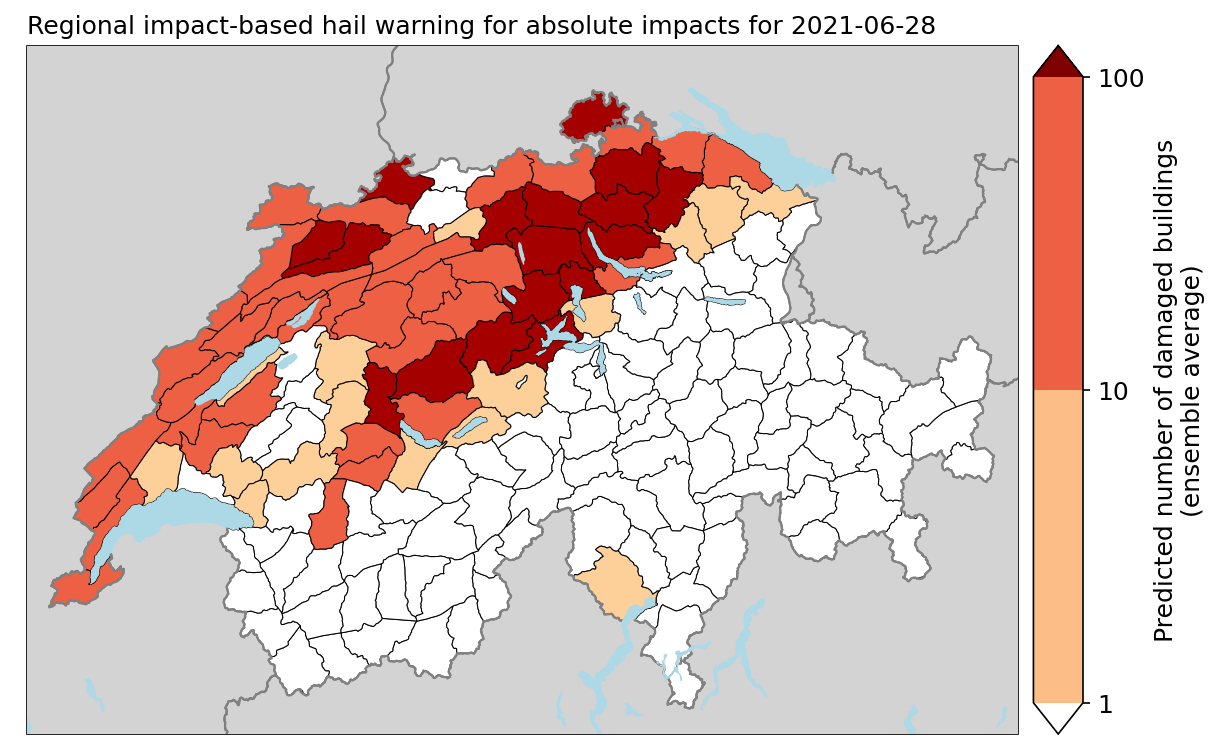

In [12]:
use_risk_threshold = True # if true, use risk threhsold, if False, use impact and agreement threshholds

# impact and agrement threhsold warning
# threshold ensemble agreement
thresh_agree = .27 # three members have to agree
member_thresh = int(n_members*thresh_agree)+1
# thresholds absolute impact
thresh_impacts = [3, 30, 300]

# risk threshold warning
# threshold risks
thresh_risks = [1, 10, 100]

example_date = "2021-06-28"
# example_date = "2021-07-12"

gdf_impact_example = gdf_impact_per_region[[col for col in gdf_impact_per_region.columns if col.startswith(example_date)]]
impact_warning_CH = np.zeros(gdf_impact_example.shape[0])
risk_warning_CH = np.zeros(gdf_impact_example.shape[0])
for thresh_impact in thresh_impacts:
    impact_exceed_CH = gdf_impact_example.values>thresh_impact
    impact_exceed_freq_CH = np.sum(impact_exceed_CH, axis=1)/impact_exceed_CH.shape[1]
    impact_warning_CH += (impact_exceed_freq_CH>thresh_agree).astype(float)

risk_CH = np.mean(gdf_impact_example.values, axis=1)
for thresh_risk in thresh_risks:
    risk_warning_CH += (risk_CH>thresh_risk).astype(float)

if use_risk_threshold:
    impact_warning_CH = risk_warning_CH
    thresh_impacts = thresh_risks

gdf_impact_example = gpd.GeoDataFrame(data=gdf_impact_example)
gdf_impact_example.geometry = [
    warning_shape.loc[warning_shape["REGION_NAM"]==region].geometry.values[0] for region in gdf_impact_example.index
]
gdf_impact_example.crs = warning_shape.crs
gdf_impact_example["warning_level"] = impact_warning_CH

# create emtpy plot for cantonal impacts
fig, ax, cbax = u_plot.create_empty_plot_CH(f"Regional impact-based hail warning for absolute impacts for {example_date}", figsize=(8,5),
                                              show_cantons=False, four_cantons=False, four_cantons_style="dashed")
cbax.set_visible(True)
ax.set_xlim(*u_plot.CH_extent_x)
ax.set_ylim(*u_plot.CH_extent_y)

# fill map
map_projection = ccrs.AlbersEqualArea(8.222665776, 46.800663464)
cmap_warning = u_plot.get_cmap_killian(name="OrRd")
cmap_warning.set_under("white")
gdf_impact_example.to_crs(map_projection).plot(ax=ax, column="warning_level", cmap=cmap_warning, vmin=.5, vmax=3, edgecolor="black", linewidth=.5)

#colorbar
bounds = (np.log10(thresh_impacts) - np.log10(thresh_impacts[0])) / (np.log10(thresh_impacts[-1]) - np.log10(thresh_impacts[0]))
norm = mpl.colors.BoundaryNorm(bounds, cmap_warning.N, extend='both')
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_warning),
            cax=cbax, orientation='vertical')
cbax.set_yticklabels([f'{np.round(bin,2)}' for bin in thresh_impacts])
cbar.set_label(f'Predicted number of damaged buildings (> {member_thresh-1} members)')
if use_risk_threshold:
    cbar.set_label(f'Predicted number of damaged buildings\n(ensemble average)')

# if use_risk_threshold:
#     fig.savefig(f"{dir_plots}/impact_warning_risks{thresh_impacts}_{model}_date{example_date}.png", bbox_inches='tight')
# else:
#     fig.savefig(f"{dir_plots}/impact_warning_agree{thresh_agree}_imp{thresh_impacts}_{model}_date{example_date}.png", bbox_inches='tight')

### Thresholds from relative values

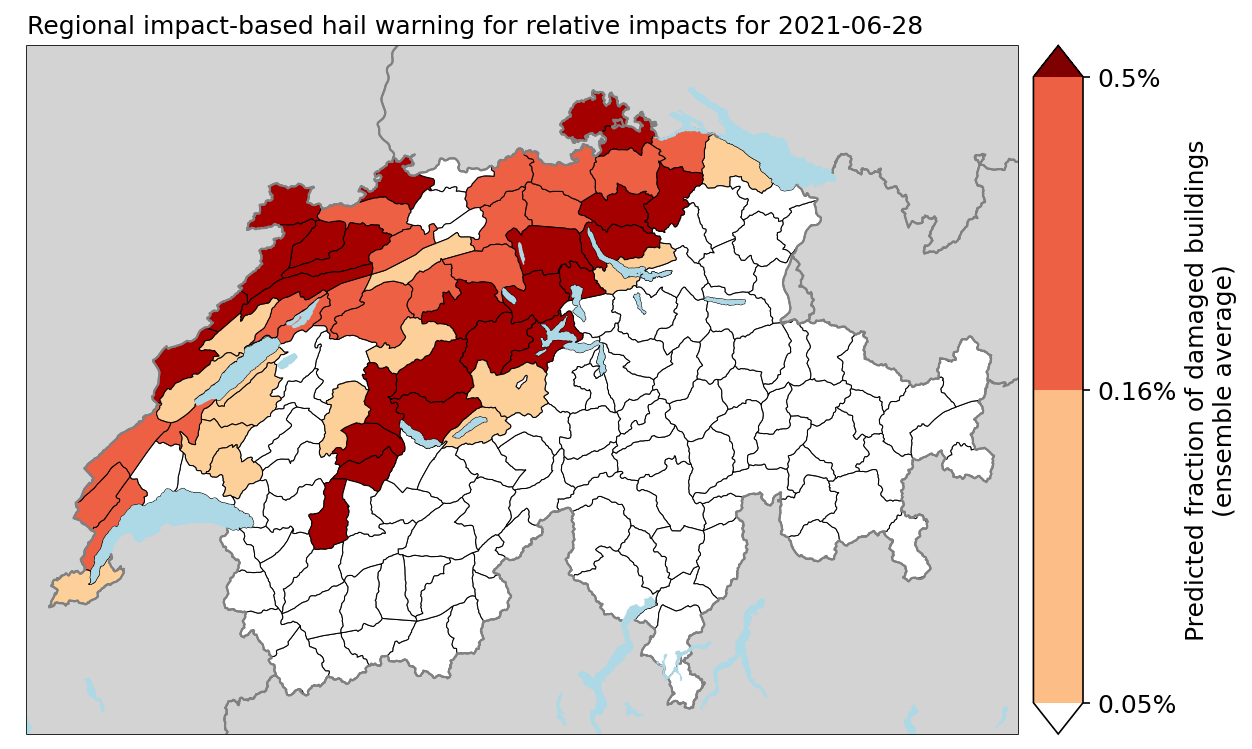

In [13]:
use_risk_threshold = True # if true, use risk threhsold, if False, use impact and agreement threshholds

# impact and agrement threhsold warning
# threshold ensemble agreement
thresh_agree = .27 # three members have to agree
member_thresh = int(n_members*thresh_agree)+1
# thresholds relative impact
thresh_impacts = [0.0005, 0.0016, 0.005] #[0.0005, 0.005, 0.05]

# risk threshold warning
# threshold risks
thresh_risks = [0.0005, 0.0016, 0.005]

example_date = "2021-06-28"
# example_date = "2021-07-12"

gdf_impact_example = gdf_rel_impact_per_region[[col for col in gdf_rel_impact_per_region.columns if col.startswith(example_date)]]
impact_warning_CH = np.zeros(gdf_impact_example.shape[0])
risk_warning_CH = np.zeros(gdf_impact_example.shape[0])

for thresh_impact in thresh_impacts:
    impact_exceed_CH = gdf_impact_example.values>thresh_impact
    impact_exceed_freq_CH = np.sum(impact_exceed_CH, axis=1)/impact_exceed_CH.shape[1]
    impact_warning_CH += (impact_exceed_freq_CH>thresh_agree).astype(float)

risk_CH = np.mean(gdf_impact_example.values, axis=1)
for thresh_risk in thresh_risks:
    risk_warning_CH += (risk_CH>thresh_risk).astype(float)
if use_risk_threshold:
    impact_warning_CH = risk_warning_CH
    thresh_impacts = thresh_risks

gdf_impact_example = gpd.GeoDataFrame(data=gdf_impact_example)
gdf_impact_example.geometry = [
    warning_shape.loc[warning_shape["REGION_NAM"]==region].geometry.values[0] for region in gdf_impact_example.index
]
gdf_impact_example.crs = warning_shape.crs
gdf_impact_example["warning_level"] = impact_warning_CH

# create emtpy plot for cantonal impacts
fig, ax, cbax = u_plot.create_empty_plot_CH(f"Regional impact-based hail warning for relative impacts for {example_date}", figsize=(8,5),
                                              show_cantons=False, four_cantons=False, four_cantons_style="dashed")
cbax.set_visible(True)
ax.set_xlim(*u_plot.CH_extent_x)
ax.set_ylim(*u_plot.CH_extent_y)

# fill map
map_projection = ccrs.AlbersEqualArea(8.222665776, 46.800663464)
cmap_warning = u_plot.get_cmap_killian(name="OrRd")
cmap_warning.set_under("white")
gdf_impact_example.to_crs(map_projection).plot(ax=ax, column="warning_level", cmap=cmap_warning, vmin=.5, vmax=3, edgecolor="black", linewidth=.5)

#colorbar
bounds = (np.log10(thresh_impacts) - np.log10(thresh_impacts[0])) / (np.log10(thresh_impacts[-1]) - np.log10(thresh_impacts[0]))
norm = mpl.colors.BoundaryNorm(bounds, cmap_warning.N, extend='both')
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_warning),
            cax=cbax, orientation='vertical')
cbax.set_yticklabels([f'{np.round(bin*100,2)}%' for bin in thresh_impacts])
cbar.set_label(f'Predicted fraction of damaged buildings (> {member_thresh-1} members)')
if use_risk_threshold:
    cbar.set_label(f'Predicted fraction of damaged buildings\n(ensemble average)')

# if use_risk_threshold:
#     fig.savefig(f"{dir_plots}/rel_impact_warning_risks{thresh_impacts}_{model}_date{example_date}.png", bbox_inches='tight')
# else:
#     fig.savefig(f"{dir_plots}/rel_impact_warning_agree{thresh_agree}_imp{thresh_impacts}_{model}_date{example_date}.png", bbox_inches='tight')